In [1]:
%matplotlib inline
import glob
import numpy as np

from __future__ import print_function,division 
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.io import fits
import datetime
import operator
import stistools as st
from itertools import zip_longest # for Python 3.x
#from itertools import izip_longest # for Python 2.x
from collections import Counter
from sklearn.preprocessing import Imputer
import pandas as pd
from scipy.cluster.vq import kmeans, vq
from astropy.stats import sigma_clip
import yaml

plt.style.use('seaborn-white')
mpl.rcParams['agg.path.chunksize'] = 10000
mpl.rcParams.update({'font.size': 18})

The following tasks in the stistools package can be run with TEAL:
   basic2d      calstis     ocrreject     wavecal        x1d          x2d


# Investigating STIS Dark Rate Temperature Sensitivity

This notebook details the repoduction of the results found in STIS ISR 2001-003 (http://www.stsci.edu/hst/stis/documents/isrs/200103.pdf). The methodology below forms the basis for the darkrate_housingtemp.py script. Much of this notebook is dependent on directories on my local machine, however this serves as a guide if anyone ever desires to reproduce this work as well. In the future, there are plans to introduces hooks in GitHub allowing access to HST data without direct binary hosting in the repository. Whenever that comes around, I hope to update this repository for better accessibility.

## Retreiving the ISR2001-003 Dataset

Below, I attempt to recreate the dataset used for the results presented in ISR2001-003. Following the ISR, I've retreived all darks taken in program 8864 and program 8901, created a subset of the data spanning from July 13,2001 to September 21,2001, split this data by anneal period, and sorted by the housing temperature provided in the headers.

In [2]:
#Glob in all possible darks from programs 8864 and 8901

#These darks have been calibrated through the CALSTIS pipeline

image_dir = "ISR2001003_data/calstis_crj/"
images = glob.glob(image_dir+"*flt.fits")
frame_hdr = fits.open(images[0])
dq_flag = (frame_hdr['DQ'].data !=16) & (frame_hdr['DQ'].data != 16384)


In [3]:
#Create a subset of images to match ISR 2001-03

#Date Range: July 13, 2001 to September 21, 2001

ISR_subset=[] #Subset of images with known housing temperatures and in the appropriate date range
dateobs_subset = []
for image in images:
    if fits.getheader(image,1)['OCCDHTAV'] != -1.0:
        datestr = fits.getheader(image)['TDATEOBS']
        yyyy,mm,dd = datestr.split('-')
        dateobs = datetime.datetime(int(yyyy),int(mm),int(dd))
        if dateobs < datetime.datetime(2001,9,22) and dateobs > datetime.datetime(2001,7,12):
            ISR_subset.append(image)
            dateobs_subset.append(dateobs)


In [4]:
#Generate Anneal boundaries

with open('anneal_boundaries_v2.yml') as f:
    boundaries = yaml.load(f)
    
ann_hist = []
for region in range(len(boundaries)):
    ann_hist.append(boundaries[region]['start'])

In [5]:
#Define Date Range of observations, in this case focusing on ISR 2001 dates

start_time = datetime.datetime(2001,7,13)
end_time = datetime.datetime(2001,9,22)

anneals = np.array(ann_hist)[(np.array(ann_hist) < end_time) & (np.array(ann_hist) > start_time)]
print(anneals)

[datetime.datetime(2001, 7, 27, 15, 6, 39)
 datetime.datetime(2001, 8, 20, 10, 57, 50)
 datetime.datetime(2001, 9, 21, 11, 14, 45)]


In [6]:
#Split subset into groups based on anneal history

#Manually specify 3 anneal periods as was present in ISR 2001-03
#Note: darkrate_housingtemp.py creates anneal periods autonomously

ann1=[]
ann2=[]
ann3=[]

for image in ISR_subset:
    yyyy,mo,dd = fits.getheader(image)['TDATEOBS'].split('-')
    hh,mn,ss = fits.getheader(image)['TTIMEOBS'].split(':')
    im_datetime = datetime.datetime(int(yyyy),int(mo),int(dd),int(hh),int(mn),int(ss))
    #print(fits.getheader(image)['TEXPTIME'])
    if im_datetime < anneals[0]:
        ann1.append(image)
    elif im_datetime > anneals[0] and im_datetime < anneals[1]:
        ann2.append(image)
    elif im_datetime > anneals[1]:
        ann3.append(image)
        
print(len(ann1),len(ann2),len(ann3))

30 48 64


In [7]:
#Sort each Anneal Period by temperature

#Note that this returns lists of tuples (file, temp) not just lists of filenames

ann_list = [ann1,ann2,ann3]
for ann in ann_list:
    ann_dict={}
    for file in ann:
        ann_dict[file] = fits.getheader(file,1)['OCCDHTAV']
    if ann == ann1:
        ann1_tsorted = sorted(ann_dict.items(),key=operator.itemgetter(1))
    elif ann == ann2:
        ann2_tsorted = sorted(ann_dict.items(),key=operator.itemgetter(1))
    elif ann == ann3:
        ann3_tsorted = sorted(ann_dict.items(),key=operator.itemgetter(1))
       

## Investigating the Telemetry Temperature vs the Header Temperature

Due to difficulty reproducing the exact results presented in ISR2001-003, it seems worth it to investigate alternative measurements of the Housing temperature as they apply to each dark. This is motivated as a troubleshooting step, but also to ensure that I stay as faithful to the methodology presented in the ISR as possible. The ISR claims to derive temperature from the OCCDHT telemetry file and averaging the housing temperature as a function of time over the exposure period.

In [8]:
#Read in the telemetry file for the housing temperature
#Using Pandas

hdrs = ['MJD','temp']
telem = pd.read_csv('OCCDHT',delim_whitespace=True,header=None, names=hdrs)

#Create arrays out of dataframe that are maskable
maskable_telem_mjd = np.array(telem['MJD'])
maskable_telem_temp = np.array(telem['temp'])

### Telemetry Temperature Calculation

Instead of using the header values for each dark frame, calculate a mean temperature from the nearest set of telemetry measurements. ISR2001-003 says to do this by averaging the CCD housing temperature as a function of time over the period the exposure spans. Below, I will curve fit the masked telemetry measurements and calculate an average for each exposure period. Due to some poor fitting for exposures where measurements occured inside the exposure time, I've calculated those temperatures directly as an average of the measurements taken in the exposure time.

In [9]:
#Calculate telemetry measurements for each exposure

#Initialize pandas dataframes for each anneal period
df_ann1 = pd.DataFrame(columns = ['Dark','Header Temp', 'Telem Temp', 'Difference'])
df_ann2 = pd.DataFrame(columns = ['Dark','Header Temp', 'Telem Temp', 'Difference'])
df_ann3 = pd.DataFrame(columns = ['Dark','Header Temp', 'Telem Temp', 'Difference'])
ann_dfs = [df_ann1,df_ann2,df_ann3]

#Iterate over each anneal period
for ann in [ann1_tsorted,ann2_tsorted,ann3_tsorted]:
    idx = [ann1_tsorted,ann2_tsorted,ann3_tsorted].index(ann)
    darks = []
    t_hdr = []
    t_avgs = []
    diff = []
    
    #Iterate over each (file,temp) tuple in the anneal period
    for file in ann:
        image = file[0]
        mjd_start = fits.getheader(image)['TEXPSTRT']
        mjd_end = fits.getheader(image)['TEXPEND']
        hdr_temp = fits.getheader(image,1)['OCCDHTAV']
        maskable_telem_mjd = np.array(telem['MJD'])
        maskable_telem_temp = np.array(telem['temp'])
        exp_mask = (maskable_telem_mjd <= mjd_end) & (maskable_telem_mjd >= mjd_start)
        mjd_exp_subset = maskable_telem_mjd[exp_mask]
        t_exp_subset = maskable_telem_temp[exp_mask]
        
        # If there are measurements made inside the MJD range of the exposure itself, average those for the temp.
        if len(mjd_exp_subset) != 0:
            t_avg = np.sum(t_exp_subset)/len(t_exp_subset)
            
        # If not, create a polyfit of nearby points and average the fitted curve over the exposure length.
        else:
            mjd_mask = (maskable_telem_mjd <= mjd_end + 0.1) & (maskable_telem_mjd >= mjd_start - 0.1)

            mjd_subset = maskable_telem_mjd[mjd_mask]
            temp_subset = maskable_telem_temp[mjd_mask]
            temp_fit = np.polyfit(mjd_subset,temp_subset,2)
            p = np.poly1d(temp_fit)

            n_bins = 15
            exp_linspace = np.linspace(mjd_start,mjd_end,n_bins)
            t_avg = np.sum(p(exp_linspace))/n_bins
        
        #Store these calculations into lists
        darks.append(image)
        t_hdr.append(hdr_temp)
        t_avgs.append(t_avg)
        diff.append(t_avg-hdr_temp)

    #Store into anneal dataframes   
    d = {'Dark': darks, 'Header Temp': t_hdr, 'Telem Temp':t_avgs, 'Difference':diff}
    cols = ['Dark','Header Temp', 'Telem Temp', 'Difference']
    ann_dfs[idx]=pd.DataFrame(data=d)[cols]

#Poor object assignment, reassign the anneal dataframes (likely the above assignments are unneeded)
df_ann1 = ann_dfs[0]
df_ann2 = ann_dfs[1]
df_ann3 = ann_dfs[2]

/Users/dbranton/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:39: RankWarning: Polyfit may be poorly conditioned


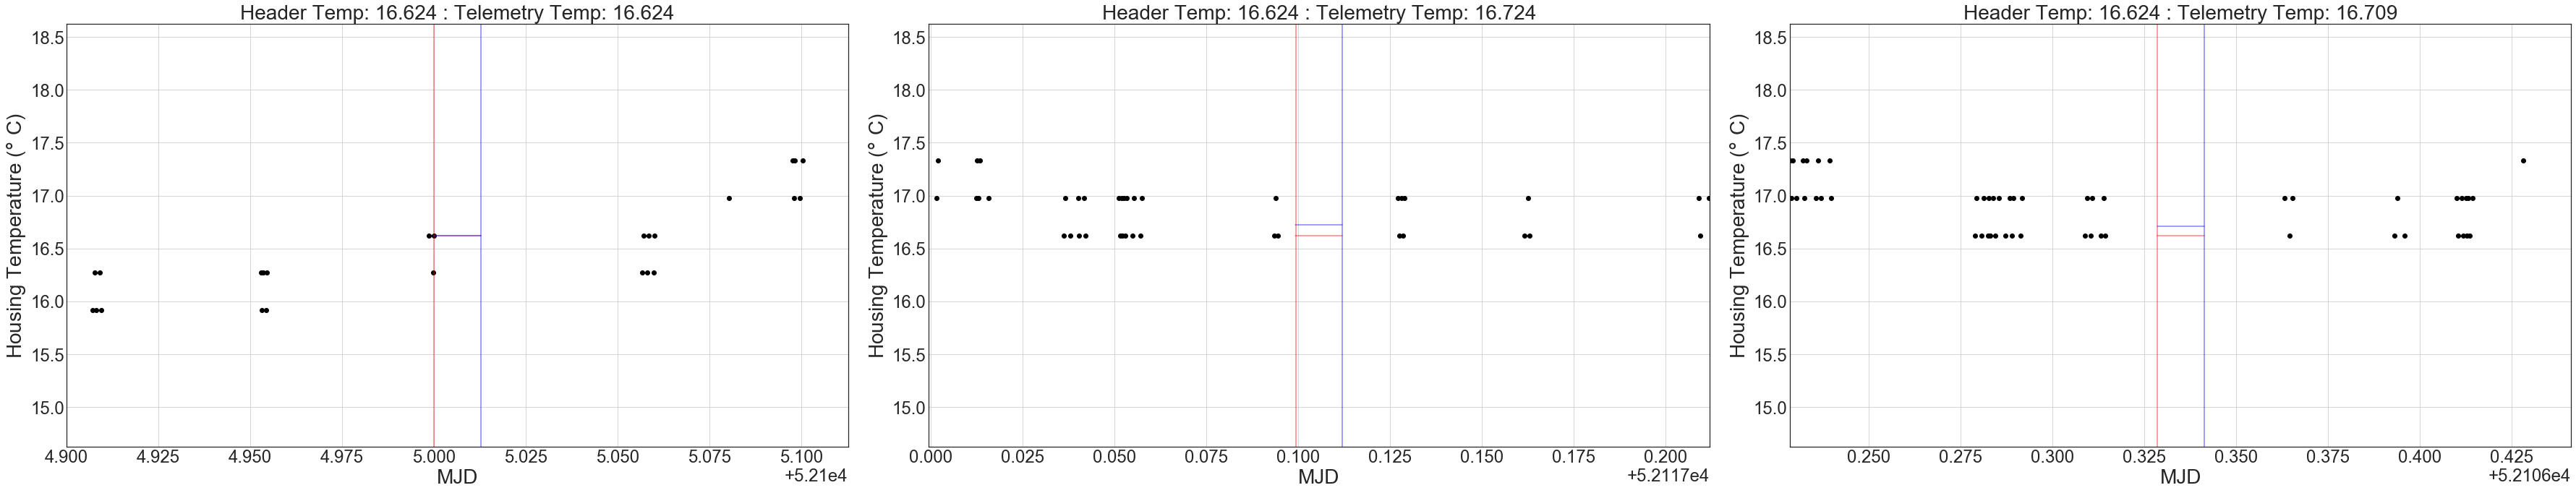

In [10]:
#See how these calculated temperatures compare against the header values (anneal period 3)

#Red and Blue Vertical Lines are Exposure start and stop times
#Black datapoints are nearby telemetry measurements
#Red Horizontal line is header value for temperature
#Blue Horizontal line is calculated temperature from telemetry

mpl.rcParams.update({'font.size': 24})

fig = plt.figure(figsize=(50,10))
count=1
for row in df_ann1.iterrows():
    if count == 4:
        continue
    image = row[1][0]
    hdr_temp = row[1][1]
    telem_temp = row[1][2]
    mjd_start = fits.getheader(image)['TEXPSTRT']
    mjd_end = fits.getheader(image)['TEXPEND']
    mjd_mask = (maskable_telem_mjd <= mjd_end + 1) & (maskable_telem_mjd >= mjd_start - 1)
    mjd_subset = maskable_telem_mjd[mjd_mask]
    temp_subset = maskable_telem_temp[mjd_mask]
    ax = fig.add_subplot(1,3,count)
    count+=1
    ax.plot(mjd_subset,temp_subset,'.',alpha=1,color='k',markersize=12)
    ax.axvline(mjd_start,color='r',label=hdr_temp,alpha=0.5)
    ax.set_title('Header Temp: {:{prec}}'.format(hdr_temp,prec='.5')+' : Telemetry Temp: {:{prec}}'.format(telem_temp,prec='.5'),fontsize=28)
    ax.axhline(y=hdr_temp,color='r',xmin=0.47, xmax=0.53,alpha=0.5)
    ax.axhline(y=telem_temp,color='b',xmin=0.47, xmax=0.53,alpha=0.5)
    ax.axvline(mjd_end,color='b',alpha=0.5)
    ax.set_xlim(mjd_start-0.1,mjd_end+0.1)
    ax.set_ylim(hdr_temp-2,hdr_temp+2)
    ax.set_xlabel('MJD',fontsize=28)
    ax.set_ylabel(r'Housing Temperature ($\degree$ C)',fontsize=28)
    ax.grid()
plt.tight_layout()
plt.savefig('Ann1_headertemp_vs_telemcalc.png')

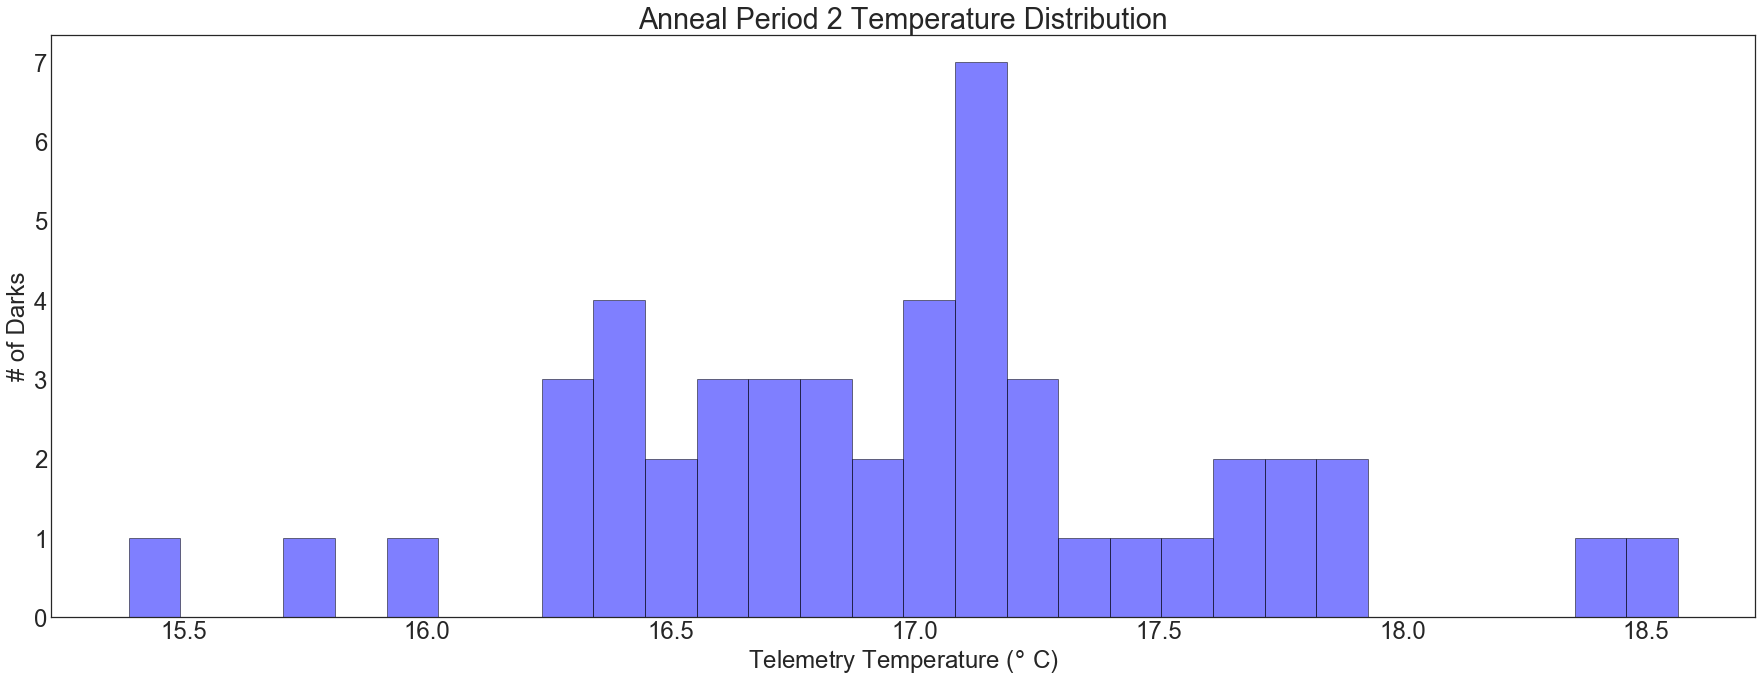

In [11]:
#Sort each Anneal Period by temperature calculated by the telemetry

#Goal here is to see if we can nicely split these darks into groups of three 
#for combination with cosmic ray rejection


df_ann1_tsorted = df_ann1.sort_values('Telem Temp')
df_ann2_tsorted = df_ann2.sort_values('Telem Temp')
df_ann3_tsorted = df_ann3.sort_values('Telem Temp')

fig = plt.figure(figsize=(25,10))
ax = fig.add_subplot(1,1,1)
#plt.plot(df_ann2_tsorted['Telem Temp'],'.')
ax.set_xlabel(r"Telemetry Temperature ($\degree$ C)")
ax.set_ylabel("# of Darks")

#Take a look at one of these to see the type of distribution present
ax.hist(df_ann2_tsorted['Telem Temp'],bins=30,alpha=0.5,color='blue',histtype='bar', ec='black')
ax.set_title("Anneal Period 2 Temperature Distribution")

plt.tight_layout()


### Clustering Darks by Temperature

The most challenging part of reproducing ISR2001-003 results is the ambiguity in the explanation of how darks were combined for OCRREJECT.

ISR2001-003:

    Groups of 3 frames, with each frame having nearly the same temperature, were combined with cosmic-ray rejection,using the OCCREJECT routine. Each resulting coadded frame was assigned a new temperature from the mean of its
    three input frames.

Particularly, figuring out what "nearly the same temperature" translates to from a threshold standpoint. After attempting some splitting algorithms, I eventually settled on a kmeans clustering algorithm via Scipy. The largest standard deviation for temperatures in a "bin" of similar darks was 0.13 degrees C. For now, I assume that is nearly the same.

In [12]:
# Cluster each anneal period by similar temperatures via a kmeans approach

ann1_temp_array = np.array(df_ann1_tsorted['Telem Temp'].tolist())
ann1_file_array = np.array(df_ann1_tsorted['Dark'].tolist())

ann2_temp_array = np.array(df_ann2_tsorted['Telem Temp'].tolist())
ann2_file_array = np.array(df_ann2_tsorted['Dark'].tolist())

ann3_temp_array = np.array(df_ann3_tsorted['Telem Temp'].tolist())
ann3_file_array = np.array(df_ann3_tsorted['Dark'].tolist())


clustered_ann1 = [0]*int(np.round(len(ann1_temp_array)/3))
clustered_ann2 = [0]*int(np.round(len(ann2_temp_array)/3))
clustered_ann3 = [0]*int(np.round(len(ann3_temp_array)/3))

np.random.seed((1000,2000))

for (ann_temp_array, ann_file_array,clustered_ann) in zip([ann1_temp_array,ann2_temp_array,ann3_temp_array],
                                                          [ann1_file_array,ann2_file_array,ann3_file_array],
                                                          [clustered_ann1,clustered_ann2,clustered_ann3]):
    codebook, _ = kmeans(ann_temp_array, int(np.round(len(ann_temp_array)/3)))  # three clusters
    cluster_indices, _ = vq(ann_temp_array, codebook)
    for (value, file, idx) in zip(ann_temp_array,ann_file_array, cluster_indices):
        if clustered_ann[idx] == 0:
            clustered_ann[idx] = []
            clustered_ann[idx].append((file,value))
        else:
            clustered_ann[idx].append((file,value))

clustered_ann3 = [cluster for cluster in clustered_ann3 if type(cluster) == list]

### OCRREJECT on Clustered Darks

Below, I combine sets of three clustered Darks using OCRREJECT from STISTOOLS. For clusters of lengths not nicely divisible by three, remainder dark frames have not been included. While a loss of data is not ideal, the point at this stage is to reproduce a specific result of ISR2001-003, which is doable without all of the data.

In [13]:
#OCRREJECT

out_dir = "ISR2001003_data/telemcalc/"

clustered_ann_list = [clustered_ann1,clustered_ann2,clustered_ann3]
f_out = open("combine_history.txt",'w')
#Iterate over each clustered anneal period (Shape = [['blah'],['blah'],['blah']])
for clustered_ann in clustered_ann_list:
    
    #Set the anneal period labels for the output file name
    if clustered_ann == clustered_ann1:
        ann_label = 'ann1'
        
    elif clustered_ann == clustered_ann2:
        ann_label = 'ann2'
        
    elif clustered_ann == clustered_ann3:
        ann_label = 'ann3'
        
    f_out.write ("----------------------\n")
    f_out.write(ann_label+"\n")
    f_out.write ("----------------------\n")   
    
    #Iterate over each cluster in the anneal period
    for cluster in clustered_ann:

        infile_list = [file[0] for file in cluster] #Just the files...
        temp_list = [file[1] for file in cluster]   #Just the temperatures...
        n_darks = len(infile_list)
        
        #Ignore any clusters which have less than 3 darks
        if n_darks >=3:
            triplet_list = list(zip_longest(*[iter(infile_list)]*3, fillvalue=None)) #Split into triplet groups
            triplet_temp = list(zip_longest(*[iter(temp_list)]*3, fillvalue=None))
            
            #If n_darks is cleanly divisible by 3, divide into threes and ocrreject
            if n_darks % 3 == 0: #3,6,...
                for num in range(len(triplet_list)):
                    infile_str = ','.join(triplet_list[num])
                    avg_t = np.mean(triplet_temp[num])
                    outname = out_dir+str(avg_t)+'_'+str(num+1)+'_'+ann_label+'_crj.fits'
                    st.ocrreject.ocrreject(infile_str,outname,all=True)
                    hdr_temps = [fits.getheader(file,1)['OCCDHTAV'] for file in triplet_list[num]]
                    f_out.write(infile_str+" --> "+outname+"\n")
                    f_out.write("Telemetry Temperatures: "+','.join(list(map(str,triplet_temp[num])))+"\n")
                    f_out.write("Header Temperatures: "+','.join(list(map(str,hdr_temps)))+"\n")
           
            #If not, ignore any remaining darks        
            elif n_darks % 3 == 1: #4,7,...
                for num in range(len(triplet_list)):
                    if None not in triplet_list[num]:
                        infile_str = ','.join(triplet_list[num])
                        avg_t = np.mean(triplet_temp[num])
                        outname = out_dir+str(avg_t)+'_'+str(num+1)+'_'+ann_label+'_crj.fits'
                        st.ocrreject.ocrreject(infile_str,outname,all=True)
                        hdr_temps = [fits.getheader(file,1)['OCCDHTAV'] for file in triplet_list[num]]
                        f_out.write(infile_str+" --> "+outname+"\n")
                        f_out.write("Telemetry Temperatures: "+','.join(list(map(str,triplet_temp[num])))+"\n")
                        f_out.write("Header Temperatures: "+','.join(list(map(str,hdr_temps)))+"\n")
                        
            #If not, ignore any remaining darks
            elif n_darks % 3 == 2: #5,8,...
                for num in range(len(triplet_list)):
                    if None not in triplet_list[num]:
                        infile_str = ','.join(triplet_list[num])
                        avg_t = np.mean(triplet_temp[num])
                        outname = out_dir+str(avg_t)+'_'+str(num+1)+'_'+ann_label+'_crj.fits'
                        st.ocrreject.ocrreject(infile_str,outname,all=True)
                        hdr_temps = [fits.getheader(file,1)['OCCDHTAV'] for file in triplet_list[num]]
                        f_out.write(infile_str+" --> "+outname+"\n")
                        f_out.write("Telemetry Temperatures: "+','.join(list(map(str,triplet_temp[num])))+"\n")
                        f_out.write("Header Temperatures: "+','.join(list(map(str,hdr_temps)))+"\n")
f_out.close()

## Reproducing Figure 1

The first figure in ISR 2001-003 details the ratio of dark rates between a dark at a certain temperature and a reference dark (RF1) at a certain reference temperature. The intent is to sample the typical ratio of difference between the dark rates of two darks depending on the difference of temperature. This ratio is plotted against a second reference dark (RF2) at that same reference temperature, to avoid geometric plotting issues with using the same array in both the x and y axis. Below is an example of this plot created for a hotter dark in the first anneal period.

In [20]:
#Look at anneal period 1 as example

#Grab the Cosmic Ray Rejected files from each anneal period
a1 = glob.glob(out_dir+'*ann1*')


#Removed DQ == 16 flagged pixels from each frame
frame_hdr = fits.open(out_dir+'17.8910267741_1_ann1_crj.fits') # These change depending on kmeans runs
cntr = Counter()
for val in list(np.ravel(frame_hdr['DQ'].data)):
    cntr[val] += 1
print(cntr) # Get a sense of flagging statistics across the data array
dq_flag = (frame_hdr['DQ'].data !=16) & (frame_hdr['DQ'].data != 256)

a1_frames = {}
for frame in a1:
    frame_hdr = fits.open(frame)
    frame_data = frame_hdr['SCI'].data
    frame_data = frame_data[dq_flag]
    a1_frames[frame] = np.ravel(frame_data)
    
    
#Choose Reference Frame 1 Ann1 (Frame closest to 18 degrees C)
a1_RF1 = '17.8910267741_1_ann1_crj.fits' # These change depending on kmeans runs

a1_RF1_data =a1_frames.get(out_dir+a1_RF1)/3300

#Choose Reference Frame 2 Ann1 (Frame closest to 18 degrees C)
a1_RF2 = '18.078653954_1_ann1_crj.fits' # These change depending on kmeans runs

a1_RF2_data = a1_frames.get(out_dir+a1_RF2)/3300

a1_RF2_err = np.ravel(fits.open(out_dir + a1_RF2)['ERR'].data[dq_flag])
masked_err = a1_RF2_err[np.log10(a1_RF2_data) > -2.0]
masked_data = a1_RF2_data[np.log10(a1_RF2_data) > -2.0]*3300


Counter({0: 1004102, 16: 44108, 256: 266, 272: 100})


/Users/dbranton/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in log10
/Users/dbranton/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/Users/dbranton/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in log10
/Users/dbranton/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in greater


/Users/dbranton/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log10
  del sys.path[0]


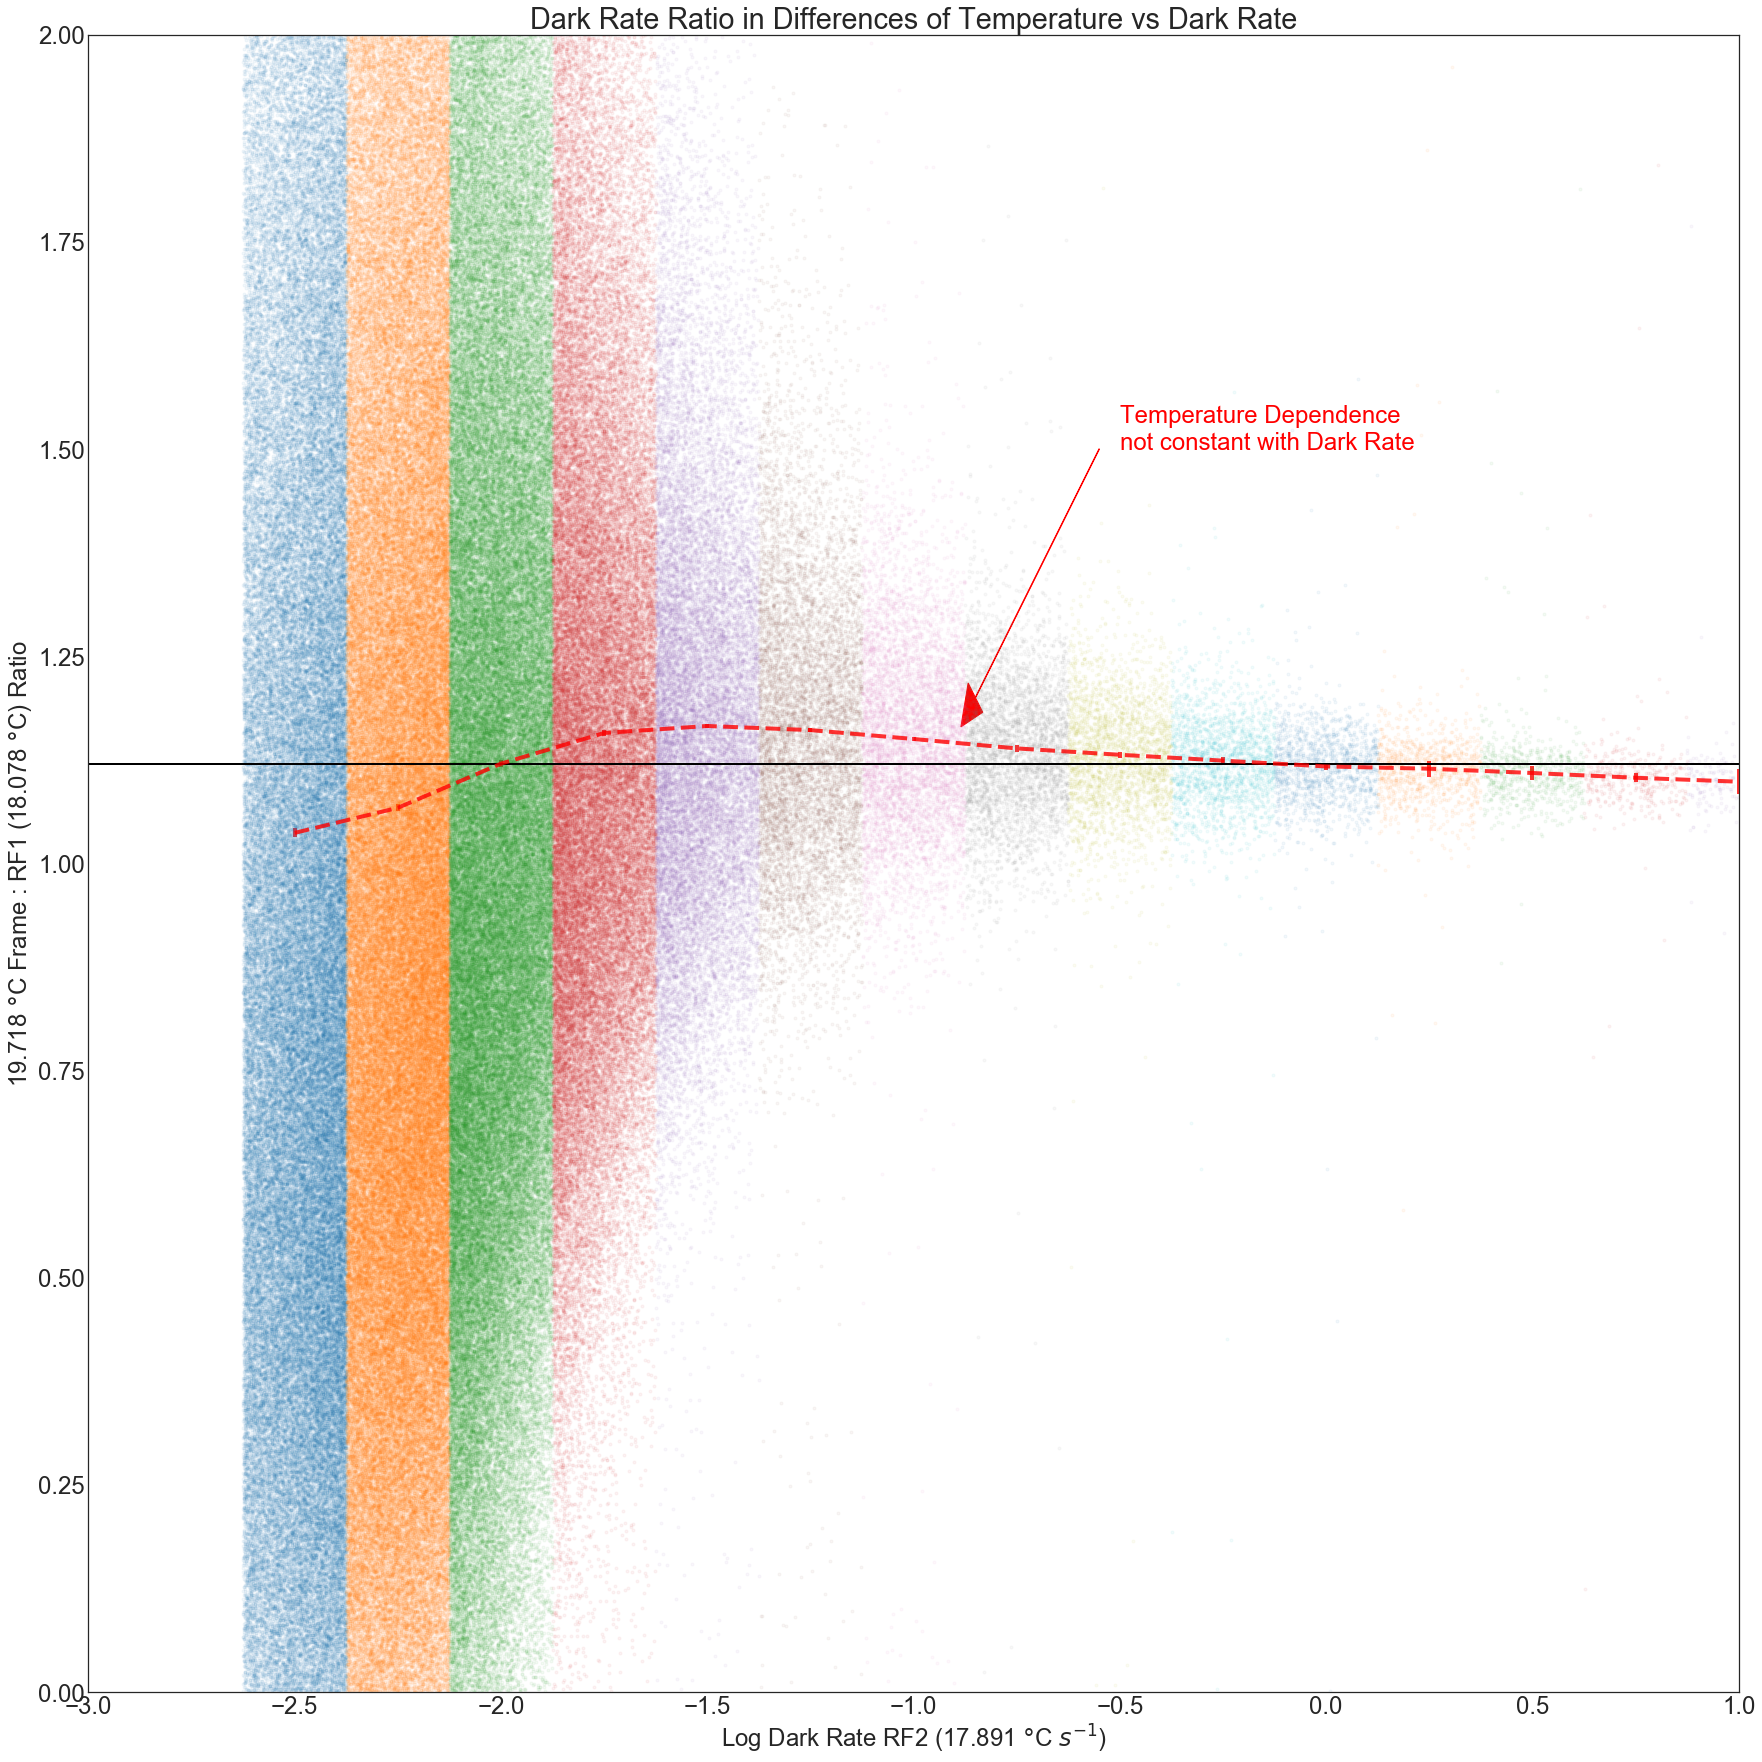

In [15]:
#Plot the ratio of the dark rate per pixel for a test frame divided by RF1 against the dark rate per pixel
#of RF2

#Choose a test frame
test_frame_name = '19.7183409585_1_ann1_crj.fits'  
test_frame = a1_frames.get(out_dir+test_frame_name)/3300 #3300 is combine exposure time
test_frame_temp = test_frame_name.split('_')[0]
test_ratio = (test_frame)/(a1_RF1_data)



#Take the log of Reference Frame 2 (Introduces Nans!)
log_RF2 = np.log10(a1_RF2_data)


#Remove NaN values
log_RF2_nonan = log_RF2[~np.isnan(log_RF2)]
test_ratio_nonan = test_ratio[~np.isnan(log_RF2)]
test_frame_nonan = test_frame[~np.isnan(log_RF2)]
RF1_nonan = a1_RF1_data[~np.isnan(log_RF2)]

#Mask out ratios below 0
ratio_mask = test_ratio_nonan >=0
log_RF2_masked = log_RF2_nonan[ratio_mask]
test_ratio_masked = test_ratio_nonan[ratio_mask]

#Sigma Clip Data
sigma = 5
test_ratio_masked_sclip = sigma_clip(test_ratio_masked,sigma=sigma)
test_ratio_masked_sclip = np.ma.compressed(test_ratio_masked_sclip)
sclip_mask = np.isin(test_ratio_masked,test_ratio_masked_sclip)
log_RF2_masked_sclip = log_RF2_masked[sclip_mask]

#Get rid of ratios that present as positive due to two negative quantities
false_mask = (test_frame_nonan > 0) * (RF1_nonan > 0)


#Calculate a Median of Column Bins along the plot and plot both the curve and a median of the curve

total_bins = 16 # 15 regions (16 bins) for median calculation
bins = np.linspace(-2.625,1.125, total_bins) #Spread these about the (rough) range of the dataset

plot_bins = np.linspace(-2.5,1.00,total_bins-1)
delta = bins[1]-bins[0]
idx  = np.digitize(log_RF2_masked_sclip,bins,right=False)
running_median = [np.median(test_ratio_masked_sclip[idx==k]) for k in range(total_bins+1)[1:-1]]
running_median_err = [1.25*np.std(test_ratio_masked_sclip[idx==k])/np.sqrt(len(test_ratio_masked_sclip[idx==k])) 
                      for k in range(total_bins+1)[1:-1]]

#Plot
fig, ax = plt.subplots(1,1,figsize = (25,25))

#Plot each bin separately, to visually distinguish boundaries (different color for each bin)
for k in range(total_bins+1)[1:-1]:
    ax.plot(log_RF2_masked_sclip[idx==k],test_ratio_masked_sclip[idx==k],'.',alpha=0.05)
    
ax.errorbar(bins[:-1]+delta/2,running_median,yerr=running_median_err,fmt='r--',lw=4,alpha=.8)

ax.set_xlim(-3,1)
ax.set_ylim(0,2)
ax.set_xlabel(r'Log Dark Rate RF2 ({:{prec}} $\degree$C '.format(a1_RF1.split('_')[0],prec='.6')+r'$s^{-1}$)',
              fontsize=24)
ax.set_ylabel(r'{:{prec}} $\degree$C Frame : RF1 ({:{prec}} $\degree$C) Ratio'.format(test_frame_temp,
            a1_RF2.split('_')[0],prec='.6'),fontsize=24)
ax.axhline(np.median(running_median), linewidth=2, color='k')
ax.text(-0.5,1.5,"Temperature Dependence\nnot constant with Dark Rate", color = 'r')
ax.arrow(-0.55, 1.5, -0.3, -0.3, head_width=0.05, head_length=0.05, fc='r', ec='r')
ax.set_title("Dark Rate Ratio in Differences of Temperature vs Dark Rate")
plt.tight_layout()



### Reproducing Figure 2

In figure 1, a median of each dark rate bin is computed for the ratio between a given dark and its associated reference darks. The next step in this analysis is to compute these medians for all the darks in each of the anneal periods. Plotting these as median ratios against temperature will provide a sense for how the dark rate scales with temperature across the dark rate range.

The following code does the legwork in grabbing darks from each anneal period and extracting median ratios and temperatures from each.

In [21]:
#Load in anneal period darks, choose reference frames (per anneal period) to compare them against 

a1 = glob.glob(out_dir+'*ann1*')
a2 = glob.glob(out_dir+'*ann2*')
a3 = glob.glob(out_dir+'*ann3*')

#Removed DQ == 16 flagged pixels from each frame
frame_hdr = fits.open(out_dir+'17.8910267741_1_ann1_crj.fits')
dq_flag = (frame_hdr['DQ'].data !=16) & (frame_hdr['DQ'].data != 256)

allframes = {}
for frame in a1+a2+a3:
    frame_hdr = fits.open(frame)
    frame_data = frame_hdr['SCI'].data
    frame_data = frame_data[dq_flag]
    allframes[frame] = np.ravel(frame_data)
    
#Choose Reference Frame 1 Ann1 (Frame closest to 18 degrees C)
a1_RF1 = '17.8910267741_1_ann1_crj.fits'
a1_RF1_data =allframes.get(out_dir+a1_RF1)/3300

#Choose Reference Frame 2 Ann1 (Frame closest to 18 degrees C)
a1_RF2 = '17.682154046_1_ann1_crj.fits'
a1_RF2_data = allframes.get(out_dir+a1_RF2)/3300

#Choose Reference Frame 1 Ann2 (Frame closest to 18 degrees C)
a2_RF1 = '16.9347256402_1_ann2_crj.fits'
a2_RF1_data =allframes.get(out_dir+a2_RF1)/3300

#Choose Reference Frame 2 Ann2 (Frame closest to 18 degrees C)
a2_RF2 = '17.0524148288_1_ann2_crj.fits'
a2_RF2_data = allframes.get(out_dir+a2_RF2)/3300

#Choose Reference Frame 1 Ann3 (Frame closest to 18 degrees C)
a3_RF1 = '17.4564455458_2_ann3_crj.fits'
a3_RF1_data =allframes.get(out_dir+a3_RF1)/3300

#Choose Reference Frame 2 Ann3 (Frame closest to 18 degrees C)
a3_RF2 = '17.5102268253_1_ann3_crj.fits'
a3_RF2_data = allframes.get(out_dir+a3_RF2)/3300


RF_list = [a1_RF1,a1_RF2,a2_RF1,a2_RF2,a3_RF1,a3_RF2]

In [22]:
# Calculate Median Dark Rate ratios per bin


total_bins = 16 # 15 regions for median calculation
bins = np.linspace(-2.625,1.125, total_bins) #Spread these about the (rough) range of the dataset
delta = bins[1]-bins[0]

#Median dark rate ratios and dark frame temperatures for anneal period 1
median_matrix1 = []
frame_temp1 = []

#Median dark rate ratios and dark frame temperatures for anneal period 2
median_matrix2 = []
frame_temp2 = []

#Median dark rate ratios and dark frame temperatures for anneal period 3
median_matrix3 = []
frame_temp3 = []

for frame in allframes:
    frame_data = allframes.get(frame)/3300 # 3300 is combined exposure time of triplet 1100s darks
    frame_err = np.ravel(fits.open(frame)['ERR'].data[dq_flag])/3300
    f_name = frame.split('/')[-1]

    #Don't try to compute ratio using the reference frames against themselves
    if f_name in RF_list:
        continue
    
    #Assign correct reference files depending on anneal period
    temp,num,ann,ext = f_name.split('_')
    if ann == 'ann1':
        RF1 = a1_RF1_data
        RF2 = a1_RF2_data
        frame_temp = frame_temp1
        median_matrix = median_matrix1

    elif ann == 'ann2':
        RF1 = a2_RF1_data
        RF2 = a2_RF2_data
        frame_temp = frame_temp2
        median_matrix = median_matrix2

    elif ann == 'ann3':
        RF1 = a3_RF1_data
        RF2 = a3_RF2_data
        frame_temp = frame_temp3
        median_matrix = median_matrix3

    else:
        continue

    ratio = frame_data/RF1
    ratio_med = np.median(ratio)

    log_RF2 = np.log10(RF2)
    
    #Remove nan values from log, equivalent move here would be to just mask out negative RF2 prior to log
    log_RF2_nonan = log_RF2[~np.isnan(log_RF2)]
    ratio_nonan = ratio[~np.isnan(log_RF2)]
    
    #Mask out negative ratios
    ratio_mask = ratio_nonan >=0
    log_RF2_masked = log_RF2_nonan[ratio_mask]
    ratio_masked = ratio_nonan[ratio_mask]
    
    #Sigma clip ratios
    ratio_masked_sclip = sigma_clip(ratio_masked,sigma=5)
    ratio_masked_sclip = np.ma.compressed(ratio_masked_sclip)
    sclip_mask = np.isin(ratio_masked,ratio_masked_sclip)
    log_RF2_masked_sclip = log_RF2_masked[sclip_mask]
    
    #Break up RF2 pixels into bins based on dark rate, calculate a running median in each bin
    idx  = np.digitize(log_RF2_masked_sclip,bins)
    running_median = [np.median(ratio_masked_sclip[idx==k]) for k in range(total_bins)]
   
    #Store medians and temperatures
    frame_temp.append(temp)
    median_matrix.append(running_median)



/Users/dbranton/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in log10


### Figure 2: Dark Rate Scaling as a Function of Temperature

With median ratios on hand for every dark, we can plot each dark rate bin separately to see how these median ratios scale with temperature. Each anneal period should be considered separately, as we cannot assume that they are standardized thermally. 

At this stage, I deviated from the process described in ISR 2001-003. While the ISR claims to have found reference frames (RF1 and RF2) at the reference temperature (18 deg C) for each anneal period, my analysis did not reliably produce darks near 18 deg C every time. Thus, I opted to just find the two nearest temperature darks and standardize in another way.

Two possible methods of standardization are:

1. Find slope of each anneal period independently and mean combine. Slope is not dependent on reference temperature so therefore we can consider each anneal by itself and take the mean of the results.

2. Fit slope to each anneal period independently, shift data so that the fit intersects a ratio of 1.0 at 18 deg C, and find the slope of all of the shifted data. Effectively standardizing each anneal period by individual fits and then looking at the combined trend.

I opted for the second method, as the resultant slope is a fit of all of the data instead of just a mean combine of seperate anneal periods. In the case of errant anneal periods, the second method handles them more as extra uncertainity than a direct shift of the reported slope as is the case with the first method.

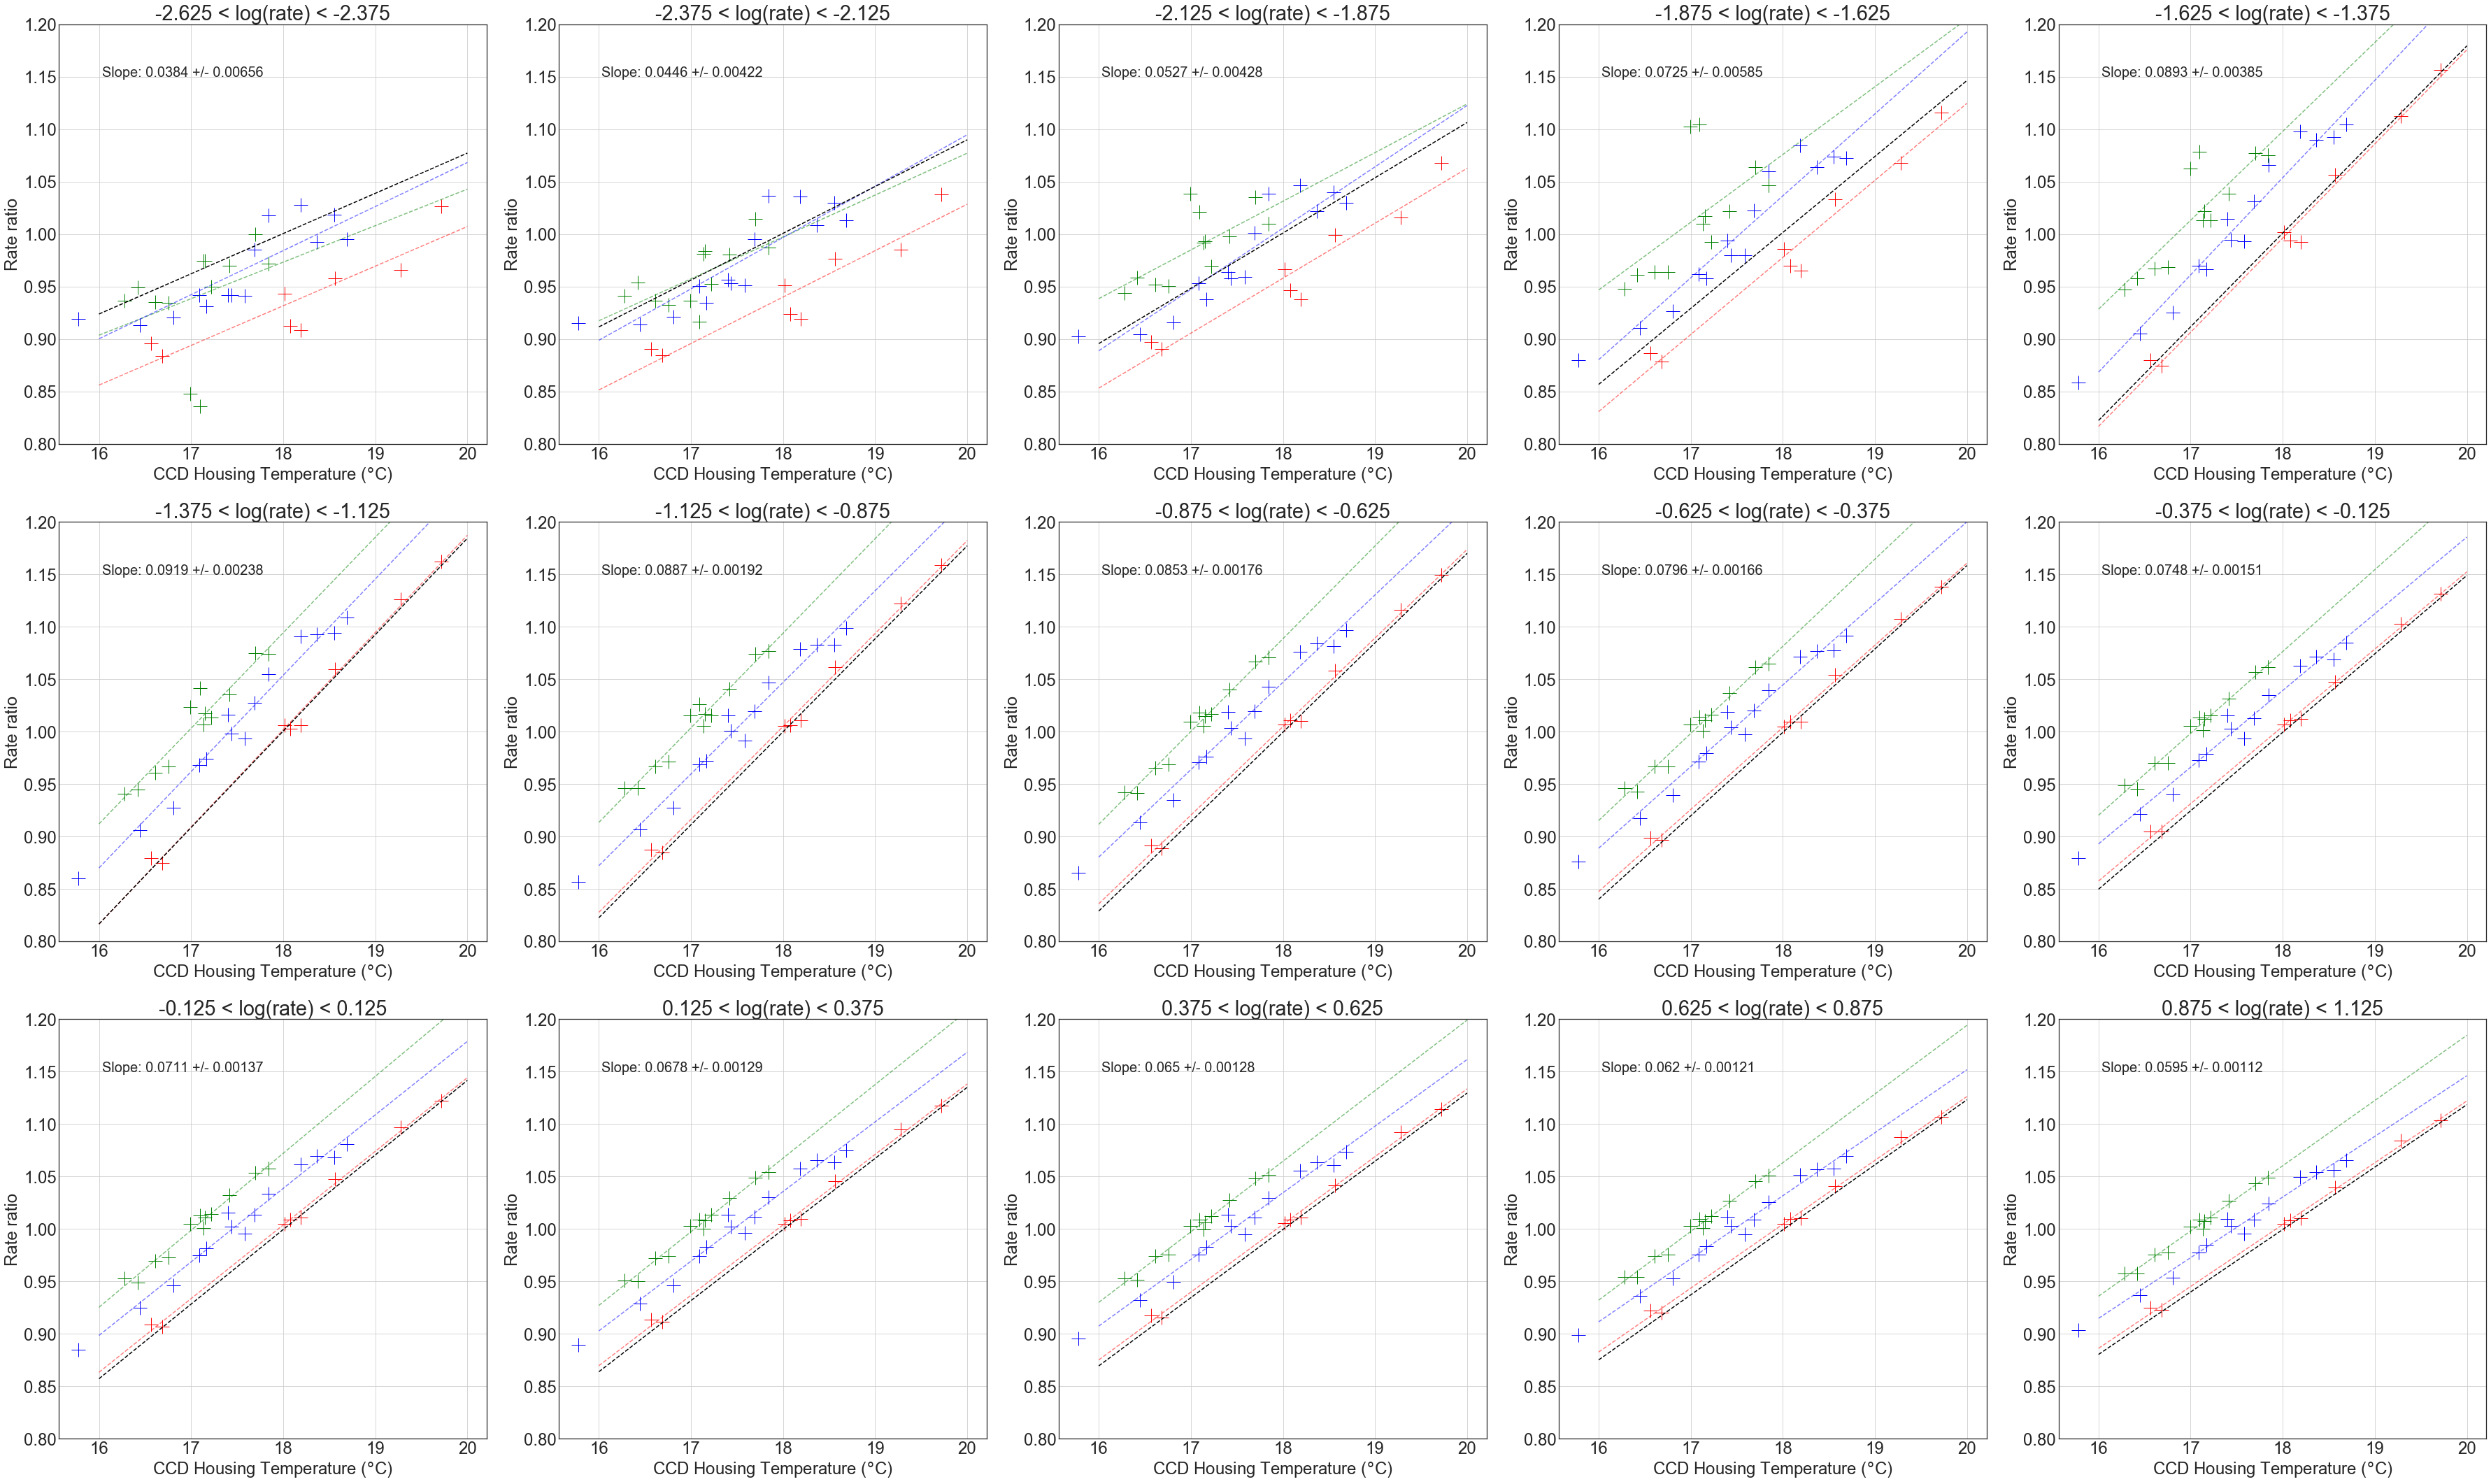

In [18]:
#Create plots per log(dark rate) bin

indx_list = np.arange(0,15,1)
fig = plt.figure(figsize=(50,30))
count=1
slope_list = []
rate_list=[]
err_list = []

#Iterate over each dark rate bin index
for indx in indx_list:
    
    #Define lower and upper bounds for each dark rate bin
    low_bound = bins[indx]
    up_bound = bins[indx+1]
    
    #Prepare rate ratio and temperature lists for each anneal period
    rate_ratio_list1 = np.array([])
    temp_list1 = np.array([])
    
    rate_ratio_list2 = np.array([])
    temp_list2 = np.array([])
    
    rate_ratio_list3 = np.array([])
    temp_list3 = np.array([])

    #Read in median rates and temperatures for each anneal period
    for f,t in zip(median_matrix1,frame_temp1):
        rate_ratio1 = f[indx]
        rate_ratio_list1 = np.append(rate_ratio_list1,float(rate_ratio1))
        temp_list1 = np.append(temp_list1,float(t))

    for f,t in zip(median_matrix2,frame_temp2):
        rate_ratio2 = f[indx]
        rate_ratio_list2 = np.append(rate_ratio_list2,float(rate_ratio2))
        temp_list2 = np.append(temp_list2,float(t))

    for f,t in zip(median_matrix3,frame_temp3):
        rate_ratio3 = f[indx]
        rate_ratio_list3 = np.append(rate_ratio_list3,float(rate_ratio3))
        temp_list3 = np.append(temp_list3,float(t))
        
    
    #Fit each anneal period with a linear function, shift data so that fit hits ratio of 1.0 at 18 deg C
    temp_fit1,res1 = np.polyfit(temp_list1,rate_ratio_list1,1,cov=True)
    s_unc1 = np.sqrt(res1[0][0])
    slope1, intercept1 = np.poly1d(temp_fit1)
    p1 = np.poly1d(temp_fit1)
    fitspace1 = np.linspace(16,20,30)
    linfit1 = p1(fitspace1)
    shift1 = p1(18.0)-1
    rate_ratio_list1_shifted = np.array(rate_ratio_list1)-shift1
    
    temp_fit2,res2 = np.polyfit(temp_list2,rate_ratio_list2,1,cov=True)
    s_unc2 = np.sqrt(res2[0][0])
    slope2, intercept2 = np.poly1d(temp_fit2)
    p2 = np.poly1d(temp_fit2)
    fitspace2 = np.linspace(16,20,30)
    linfit2 = p2(fitspace2)
    shift2 = p2(18.0)-1
    rate_ratio_list2_shifted = np.array(rate_ratio_list2)-shift2   
    
    temp_fit3,res3 = np.polyfit(temp_list3,rate_ratio_list3,1,cov=True)
    s_unc3 = np.sqrt(res3[0][0])
    slope3, intercept3 = np.poly1d(temp_fit3)
    p3 = np.poly1d(temp_fit3)
    fitspace3 = np.linspace(16,20,30)
    linfit3 = p3(fitspace3)
    shift3 = p3(18.0)-1
    rate_ratio_list3_shifted = np.array(rate_ratio_list3)-shift3   
    
    #Perform linear fit on all of the shifted anneal periods
    rate_ratio_list_shifted = np.concatenate([rate_ratio_list1_shifted,rate_ratio_list2_shifted,rate_ratio_list3_shifted])
    temp_list = np.concatenate([temp_list1,temp_list2,temp_list3])
    temp_fit,res = np.polyfit(temp_list,rate_ratio_list_shifted,1,cov=True)
    s_unc_shifted = np.sqrt(res[0][0])
    slope, intercept = np.poly1d(temp_fit)
    p = np.poly1d(temp_fit)
    fitspace = np.linspace(16,20,30)
    linfit = p(fitspace)

    mean_slope = np.mean([slope1,slope2,slope3])

    slope_list.append(slope)
    rate_list.append((up_bound+low_bound)/2)

    mean_unc = np.sum([s_unc1,s_unc2,s_unc3])/3
    err_list.append(s_unc_shifted)

    ax = fig.add_subplot(3,5,count)
    count+=1
    
    ax.plot(temp_list1,rate_ratio_list1,'+',color='r',markersize=20)
    ax.plot(temp_list2,rate_ratio_list2,'+',color='g',markersize=20)
    ax.plot(temp_list3,rate_ratio_list3,'+',color='b',markersize=20)
    ax.plot(fitspace1,linfit1,'--',color='r',alpha=0.5)
    ax.plot(fitspace2,linfit2,'--',color='g',alpha=0.5)
    ax.plot(fitspace3,linfit3,'--',color='b',alpha=0.5)
    ax.plot(fitspace,linfit,'--',color='k')
    ax.grid()
    ax.set_ylim(0.8,1.2)
    ax.set_title('{} < log(rate) < {}'.format(low_bound,up_bound))
    ax.set_ylabel('Rate ratio')
    ax.set_xlabel('CCD Housing Temperature ('+r'$\degree$'+'C)')
    ax.text(0.1, 0.9, "Slope: {:{prec}} +/- {:{prec}}".format(slope,s_unc_shifted,prec='.3'),
        verticalalignment='top', horizontalalignment='left',
        transform=ax.transAxes,fontsize = 20)
plt.tight_layout()


## Reproducing Figure 3

Figure 3 is the primary result of ISR 2001-003. We can reproduce it with little effort, by simply plotting the found slopes in Figure 2 across the dark rate bins. The result is a "Scale Value Curve", expressing the fractional change in dark rate for a degree C change in temperature. As was found in the ISR, this result is dark rate dependent. From this result, STIS introduced a flat 7%/deg C scale value correction for temperature variability on the instrument.

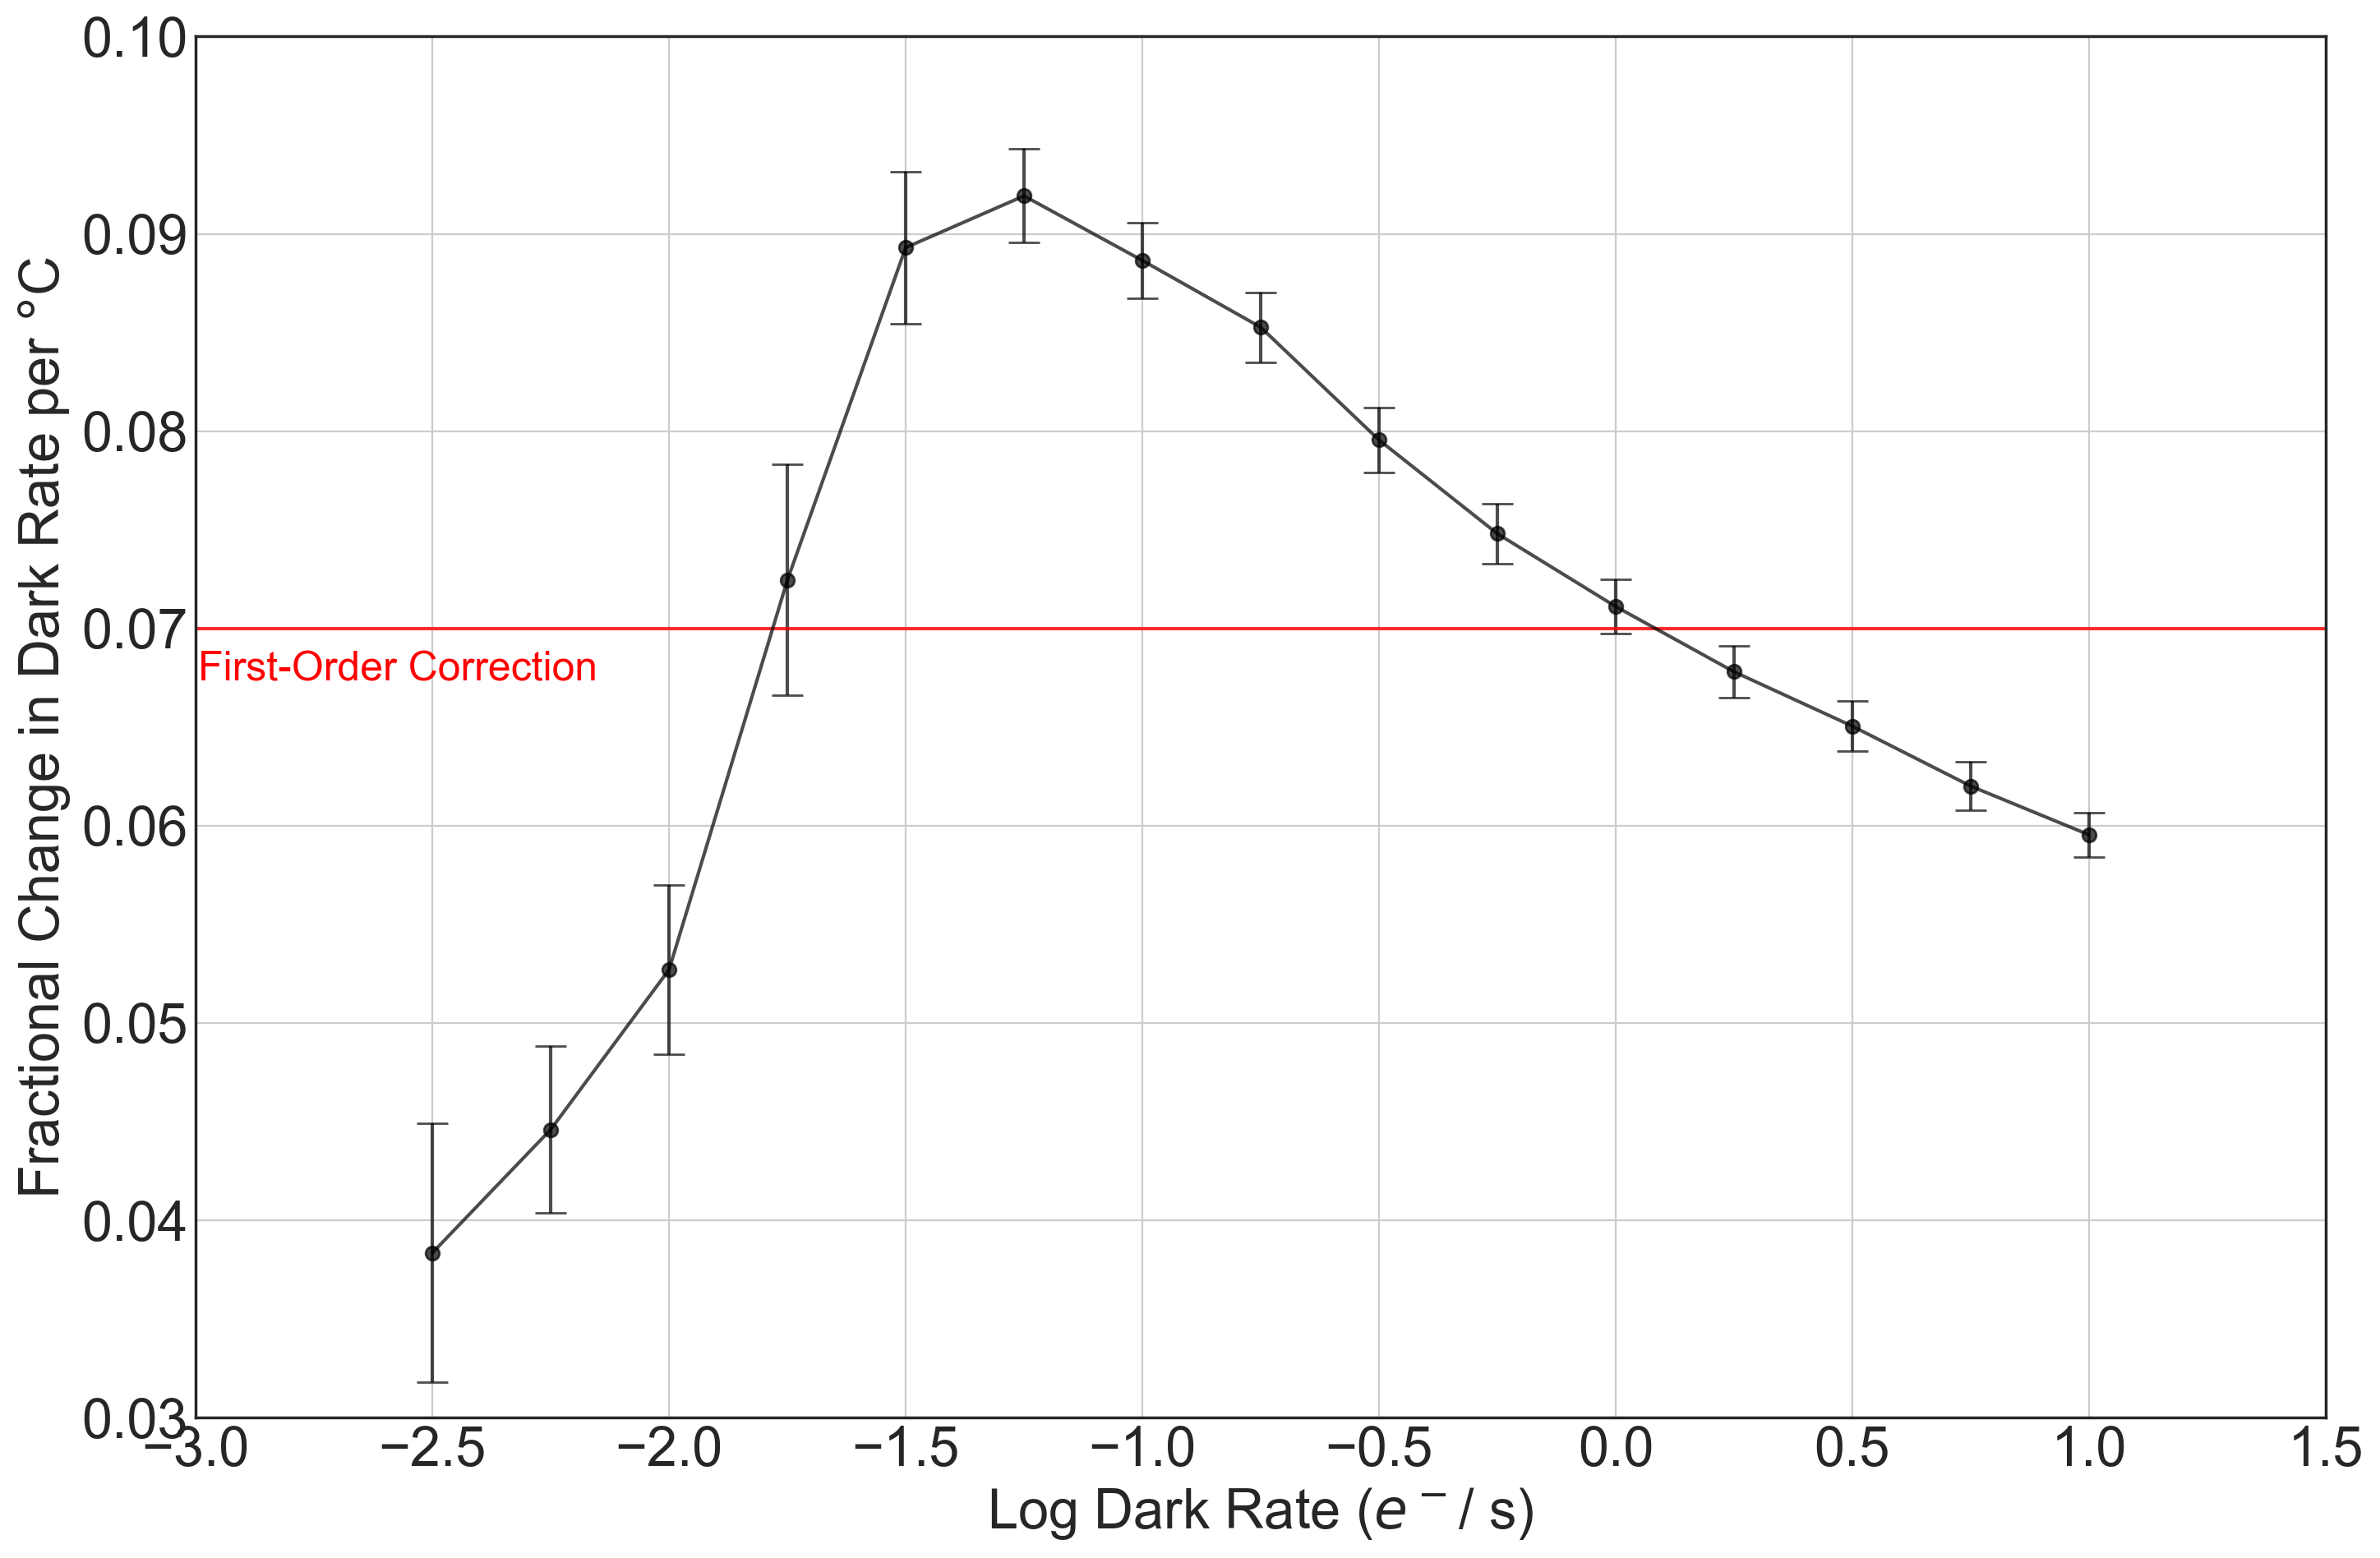

In [23]:
fig = plt.figure(figsize = (15,10))
fig.dpi = 200
ax1 = fig.add_subplot(1,1,1)
ax1.grid()
ax1.errorbar(rate_list,slope_list,yerr=err_list,fmt='o-',color='k',alpha=0.7,capsize=7)
ax1.set_ylabel(r"Fractional Change in Dark Rate per $\degree$C")
ax1.set_xlabel(r"Log Dark Rate ($e^-$/ s)")
ax1.set_ylim(0.03,0.10)
ax1.set_xlim(-3.0,1.5)
ax1.axhline(0.07, color = 'red',alpha=0.8)

ax1.text(-4.45, 1.70, "First-Order Correction",verticalalignment='top', horizontalalignment='left',
        transform=ax.transAxes,fontsize = 18,color='r')

plt.tight_layout()
